# Métodos Numéricos II. Práctica 1.

**Autor:** Arturo Olivares Martos
***

- **Asignatura:** Métodos Numéricos II.
- **Curso Académico:** 2024-25.
- **Grado:** Doble Grado en Ingeniería Informática y Matemáticas.
- **Grupo:** Único.
- **Profesor:** Juan Antonio Villegas Recio
- **Descripción:** Práctica 1 de la asignatura Métodos Numéricos II.
<!--- **Fecha:** 17 de abril de 2023. -->
<!-- - **Duración:** -->

En primer lugar, importamos las librerías necesarias para la práctica.

In [133]:
import numpy as np
from numpy import sign
import sympy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from decimal import *

Introducimos a continuación los valores máximos de iteraciones, toleracia, y precisión, que serán los que se tomen por defecto.

In [134]:
nmax = 1e3
prec = 1e-28
tol = 1e-16

## Ejercicio 1


> **Ejercicio 1.** Teniendo en cuenta la recomendación explicada sobre los criterios de parada, codifica una función similar a la explicada en el método de bisección para el método de la secante.
> 
> Aproxima la raíz de la función $f(x)=e^x-3$:
> * Cambiando la precisión a 5 cifras significativas.
> * Con la precisión por defecto y aproximando la raíz con 28 cifras significativas.

Para todos los métodos que definamos, seguiremos el mismo patrón. Devolveremos una tupla con tres valores:
1. La aproximación de la raíz.
2. El número de iteraciones empleadas.
3. El criterio de parada que se ha alcanzado.

Para poder sacar una salida legible para el usuario, definimos la siguiente función, que nos permitirá imprimir el resultado de una manera más cómoda.

In [135]:
def salida(x, niter, exit):
    """Imprime el resultado de la aproximación de la raíz.

    Args:
        x (float): Aproximación de la raíz.
        niter (int): Número de iteraciones realizadas.
        exit (str): Motivo de salida del bucle.
    """
    print(f"Numero de iteraciones: {niter}")
    if exit == 'precision':
        print(f"Posible solución exacta: {x}")
    elif exit == 'tolerancia':
        print(f"Aproximación solicitada: {x}")
    elif exit == 'denominador cero':
        print("El denominador se volvió cero, no se puede continuar.")
        print(f"Última aproximación: {x}")
    elif exit == 'iteraciones':
        print("Se alcanzó el número máximo de iteraciones.")
        print(f"Última aproximación: {x}")

Definimos ahora la función $f(x)=e^x-3$, que es la que buscaremos aproximar en los primeros ejemplos. Puesto que se trata de aproximaciones de cálculo numérico, emplearemos la versión de la exponencial que nos proporciona la librería de Python `numpy`.

In [136]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = e^x - 3$.
    """
    return np.exp(x) - 3

Por su uso en varios ejercicios, dibujaremos esta función para poder conocer intuitivamente su comportamiento. Para ello, en primer lugar definimos una función que nos permita graficar la función $f(x)$ de forma general. Previamente definiremos una función que, dado una función de Python `f` que represente una función matemática, nos proporciona la expresión de la función formateada para $\LaTeX$, algo útil para los títulos de los gráficos.

In [137]:
import inspect
import re


def obtener_funcion(f):
    """
    Obtiene la función como string a partir de su definición.

    Args:
        f (function): Función a convertir a string.
    Returns:
        str: Representación en string de la función.
    """

    source = inspect.getsource(f)
    expression = source.split('return')[1].strip()

    # Si pone NewtonHorner, se trata de un polinomio
    if 'NewtonHorner' in expression:
        coefs = expression.split('[')[1].split(']')[0].split(',')
        # Invertimos los coeficientes para que el último sea el de mayor grado
        coefs = coefs[::-1]
        expression = ""
        for i in range(len(coefs)):
            if coefs[i] != '0':
                coef = coefs[i]
                if coef == '1' or coef == '-1':
                    coef = ''
                if i == 0:
                    expression = f"{coef}" + expression
                elif i == 1:
                    expression = f"{coef}x" + expression
                else:
                    expression = f"{coef}x^({i})" + expression

                # Poner un signo + o - entre los términos si no los lleva ya
                if i != len(coefs) - 1:
                    if expression[0] != '-' and expression[0] != '+':
                        if sign(float(coefs[i])) == 1:
                            expression = f"+ {expression}"
                        else:
                            expression = f"- {expression}"
        



    # Resto, necesario para los que no son polinomios
    expression = expression.replace('(', '{')
    expression = expression.replace(')', '}')
    expression = expression.replace('{{', '\\left(')
    expression = expression.replace('}}', '\\right)')
    expression = expression.replace('**', '^')
    expression = expression.replace('*', '\\cdot ')
    expression = expression.replace('np.exp', 'e^')
    expression = expression.replace('np.cos', '\\cos ')
    expression = expression.replace('np.sin', '\\sin ')
    expression = expression.replace('np.pi', '\\pi ')

    #{algo}/{algo} se convierte en \frac{algo}{algo}
    expression = re.sub(r'{([^{}]+)}/{([^{}]+)}', r'\\frac{\1}{\2}', expression)


    return expression

In [138]:
def dibuja_funcion(f, a=-1, b=1, numpuntos=1000, titulo=True, forzar_ejeX_0=False, forzar_ejeY_0=False, Y_X=False):
    """
    Dibuja la función f(x) en el intervalo [a, b].

    Args:
        f (function): Función a graficar.
        a (float): Límite inferior del intervalo.
        b (float): Límite superior del intervalo.
        numpuntos (int): Número de puntos a graficar.
        titulo (bool): Si True, muestra el título de la función.
        forzar_ejeX_0 (bool): Si True, fuerza el eje X a pasar por 0.
        forzar_ejeY_0 (bool): Si True, fuerza el eje Y a pasar por 0.
        Y_X (bool): Si True, representa la recta Y=X.
    """
    x_valores = np.linspace(a, b, 1000)
    y_valores = f(x_valores)

    fig, ax = plt.subplots()

    # Si queremos evitar que se dibujen los ejes derecho y superior de la figura
    ax.spines['right'].set_color('none')    # borde derecho
    ax.spines['top'].set_color('none')      # borde superior

    # Fijar la posición de las marcas en la parte inferior
    ax.xaxis.set_ticks_position('bottom')
    # Situar el eje Ox.
    # Si tenemos garantizado que el 0 pertece a la imagen, situamos el eje en el 0
    # Si no sabemos si pertence o no, lo situamos en el valor medio de [f(a),f(b)]
    if ((f(a) * f(b)) > 0) and not forzar_ejeX_0:
        pos_y = (f(a) + f(b)) / 2
    else:
        pos_y = 0
    ax.spines['bottom'].set_position(('data',pos_y))


    # Fijar la posición de las marcas a la izquierda del eje Oy
    ax.yaxis.set_ticks_position('left')
    # Situar el eje Oy.
    # Si el 0 pertenece a [a,b], situamos el eje en el 0
    # Si no, lo situamos en el valor medio de [a,b]
    if ((a * b) > 0) and not forzar_ejeY_0:
        pos_x = (a + b) / 2
    else:
        pos_x = 0
    ax.spines['left'].set_position(('data',pos_x))

    # Mostramos el gráfico despues de las modificaciones
    ax.plot(x_valores, y_valores, label='f(x)')

    # Título del gráfico en Latex
    if (titulo):
        ax.set_title(f'$f(x) = {obtener_funcion(f)}$')

    # Si queremos representar la recta Y=X
    if Y_X:
        ax.plot(x_valores, x_valores, label='y=x')
        ax.legend()

La gráfica por tanto de nuestra función $f(x) = e^x - 3$ es la siguiente:

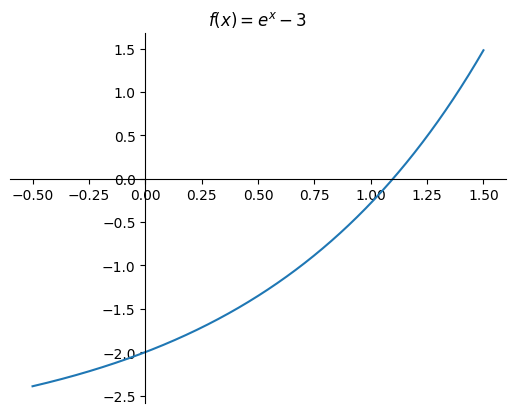

In [139]:
dibuja_funcion(f, -0.5, 1.5)

Una vez establecido lo básico, codificamos la función del método de la secante.

In [140]:
def secante(f, x0, x1, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de la secante.

    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        x1 (float): Segunda aproximación inicial. Semilla.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.

    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula de la secante fue cero.
    """
        
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n = x1
    x_n_1 = x0
    niter = 1


    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_n_2 = x_n_1
        x_n_1 = x_n

        numerador = x_n_1 - x_n_2
        denominador = f(x_n_1) - f(x_n_2)
        if denominador == 0:
            return x_n_1, niter, 'denominador cero'
        x_n = x_n_1 - (f(x_n_1) * numerador) / denominador
        
        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False
            

    return x_n, niter, exit

Aproximamos ahora la raíz con la precisión de 5 cifras significativas. No obstante, antes de aproximarla, como sabemos que la raíz es $\ln(3)$, imprimiremos su valor exacto para poder comparar.

In [141]:
print(f"Solución exacta: {sp.N(sp.log(3), 28)}")
getcontext().prec = 5
x_n, niter, exit = secante(f, Decimal(0), Decimal(3))
salida(x_n, niter, exit)


Solución exacta: 1.098612288668109691395245237
Numero de iteraciones: 8
Posible solución exacta: 1.0986


Como vemos, nos informa de una posible solución exacta, aunque el valor no tiene una precisión muy alta. Comprobemos ahora el valor con 28 cifras significativas.

In [142]:
getcontext().prec = 28
x_n, niter, exit = secante(f, Decimal(0), Decimal(3))
salida(x_n, niter, exit)

Numero de iteraciones: 12
Posible solución exacta: 1.098612288668109691395245237


Como vemos, en el ejemplo anterior no nos garantiza que sea una solución exacta, puesto que la tolerancia establecida no es suficientemente pequeña. En el siguiente ejemplo modificaremos el valor de la tolerancia.

In [143]:
x_n, niter, exit = secante(f, Decimal(0), Decimal(3), tol=1e-28)
salida(x_n, niter, exit)

Numero de iteraciones: 12
Posible solución exacta: 1.098612288668109691395245237


## Ejercicio 2

> **Ejercicio 2.** Teniendo en cuenta estos primeros pasos, codifica una función para el método de Wittaker.
> 
> Aproxima la raíz de la función $f(x)=e^x-3$:
> * Cambiando la precisión a 5 cifras significativas.
> * Con la precisión por defecto y aproximando la raíz con 28 cifras significativas.
> 
> Comprueba que una mala elección de $m$ puede provocar que la sucesión no converja.

Codificamos en primer lugar la función del método de Wittaker.

In [144]:
def wittaker(f, x0, m, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de la Wittaker.

    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        m (float): Parametro del método de Wittaker.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.

    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula fue cero.
    """
        
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n = x0

    # Comprobamos que el parámetro m no sea cero
    if m == 0:
        return x_n, niter, 'denominador cero'


    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_n_1 = x_n

        x_n = x_n_1 - (f(x_n_1)/m)
        
        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False

    return x_n, niter, exit

Aproximamos ahora la raíz con la precisión de 5 cifras significativas. No obstante, antes de aproximarla, como sabemos que la raíz es $\ln(3)$, imprimiremos su valor exacto para poder comparar.

In [145]:
print(f"Solución exacta: {sp.N(sp.log(3), 28)}")
getcontext().prec = 5
x_n, niter, exit = wittaker(f, Decimal(0), m=3)
salida(x_n, niter, exit)

Solución exacta: 1.098612288668109691395245237
Numero de iteraciones: 4
Posible solución exacta: 1.0986


Como vemos, nos informa de una posible solución exacta, aunque el valor no tiene una precisión muy alta. Comprobemos ahora el valor con 28 cifras significativas.

In [146]:
getcontext().prec = 28
x_n, niter, exit = wittaker(f, Decimal(0), m=3, tol=1e-28)
salida(x_n, niter, exit)

Numero de iteraciones: 7
Posible solución exacta: 1.098612288668109691395245237


El siguiente ejemplo muestra que una mala elección de $m$ puede provocar que la sucesión no converja.

In [147]:
x_n, niter, exit = wittaker(f, 0, m=0.1)
salida(x_n, niter, exit)

Numero de iteraciones: 1000
Se alcanzó el número máximo de iteraciones.
Última aproximación: -4851621964.097902


## Ejercicio 3

> **Ejercicio 3.** Modifique el método anterior para que, en lugar de fijar una pendiente $m$, calcule en cada iteración la derivada de la función en dicho punto, obteniendo el método de Newton-Raphson. Con este método:
> 
> Aproxima la raíz de la función $f(x)=e^x-3$:
> * Cambiando la precisión a 5 cifras significativas.
> * Con la precisión por defecto y aproximando la raíz con 28 cifras significativas.
> 
> Compare, en iguales condiciones, el rendimiento de Newton-Raphson con respecto al método de Wittaker.

En este caso, tenemos que calcular la derivada de $f$. Para este caso concreto podríamos calcular la derivada de forma algebraica y definir una función para evaluarla, pero esto no sería genérico. Podríamos definir $f$ con el módulo `sympy`, que nos permite calcular derivadas simbólicamente, pero tendríamos que tener dos definiciones de $f$, una simbólica y otra numérica. Como el valor algebraico no nos interesa, sino que tan solo necesitamos el valor numérico de la derivada, emplearemos la fórmula de la diferencia centrada para calcular la derivada numéricamente.

Notemos que esto provoca que nuestros resultados sean menos precisos, puesto que aquí ya estamos introduciendo un error. Por tanto, posiblemente en algún caso sea necesario calcular alguna iteración más para conseguir la precisión deseada.

In [193]:
def df(x, h=1e-4):
    """
    Función para calcular numéricamente $f'(x)$.
    """

    # Aunque no es buena práctica, es necesario.
    # En el ejemplo del coseno tendremos que pasarle un float, y float no puede operar con Decimal
    if isinstance(x, np.ndarray):
        h = float(h)
    elif not isinstance(h, type(x)):
        h = type(x)(h)
    
    return (f(x + h) - f(x - h)) / (2 * h)

Codificamos ahora función del método de Newton-Raphson.

In [194]:
def newtonRaphson(f, x0, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de Newton-Raphson.

    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.

    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula fue cero.
    """
        
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n = x0


    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_n_1 = x_n

        derivada = df(x_n_1)
        if derivada == 0:
            return x_n_1, niter, 'denominador cero'

        x_n = x_n_1 - (f(x_n_1)/derivada)
        
        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False

    return x_n, niter, exit

Aproximamos ahora la raíz con la precisión de 5 cifras significativas. No obstante, antes de aproximarla, como sabemos que la raíz es $\ln(3)$, imprimiremos su valor exacto para poder comparar.

In [150]:
print(f"Solución exacta: {sp.N(sp.log(3), 28)}")
getcontext().prec = 5
x_n, niter, exit = newtonRaphson(f, Decimal(0))
salida(x_n, niter, exit)

Solución exacta: 1.098612288668109691395245237
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 5
Posible solución exacta: 1.0986


Como vemos, nos informa de una posible solución exacta, aunque el valor no tiene una precisión muy alta. Comprobemos ahora el valor con 28 cifras significativas.

In [151]:
getcontext().prec = 28
x_n, niter, exit = newtonRaphson(f, Decimal(0), tol=1e-28)
salida(x_n, niter, exit)

h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 8
Posible solución exacta: 1.098612288668109691395245237


Comparamos ahora en iguales condiciones el rendimiento de Newton-Raphson con respecto al método de Wittaker. Vemos que, en algunos casos, Wittaker puede dar mejores resultados que Newton-Raphson (caso $m=3$). No obstante, vemos que esto depende claramente de la elección de $m$, por lo que no es un método recomendable.

In [152]:
x_n, niter, exit = wittaker(f, Decimal(0), m=3, tol=1e-28)
print("-------------- Wittaker m=3 --------------")
salida(x_n, niter, exit)
print("\n")

x_n, niter, exit = wittaker(f, Decimal(0), m=1, tol=1e-28)
print("-------------- Wittaker m=1 --------------")
salida(x_n, niter, exit)
print("\n")

x_n, niter, exit = newtonRaphson(f, Decimal(0), tol=1e-28)
print("-------------- Newton-Raphson --------------")
salida(x_n, niter, exit)



-------------- Wittaker m=3 --------------
Numero de iteraciones: 7
Posible solución exacta: 1.098612288668109691395245237


-------------- Wittaker m=1 --------------
Numero de iteraciones: 1000
Se alcanzó el número máximo de iteraciones.
Última aproximación: -1.371466767619718594620968608


h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
-------------- Newton-Raphson --------------
Numero de iteraciones: 8
Posible solución exacta: 1.098612288668109691395245237


## Ejercicio 4

> **Ejercicio 4.** Demuestre que la ecuación  $x^3+4 x^2=10  $  tiene una única raíz en el intervalo $[1,2]$.  Aproxime dicha raíz con el método de bisección con al menos 3 cifras decimales exactas. ¿Cuántas iteraciones serán necesarias para conseguir 5 cifras decimales exactas (tol =$10^{-5}$)?  Aproxime también la raíz con el método de Newton-Raphson partiendo del extremo adecuado hasta que la diferencia en valor absoluto, entre dos aproximaciones consecutivas sea  inferior a  $10^{-3}$.

Definimos por tanto la nueva versión de la función $f(x)$, que es la que buscaremos aproximar en este ejercicio. Como se trata de un polinomio, emplearemos el algoritmo de Newton-Horner para evaluar la función.

In [153]:
def NewtonHorner (coeficientes, x):
    """
    Método de Horner para evaluar un polinomio.

    Args:
        coeficientes (list): Coeficientes del polinomio.
        x (float): Valor en el que se evalúa el polinomio.

    Returns:
        float: Valor del polinomio evaluado en x.
    """
    resultado_f = coeficientes[0]
    for i in range(1, len(coeficientes)):
        resultado_f = resultado_f * x + coeficientes[i]
    return resultado_f

In [154]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = x^3+4x^2-10$.
    """
    return NewtonHorner([1,4,0,-10], x)

Sabemos que $f$ es continua por ser un polinomio. Para comprobar que tiene una única raíz de forma totalmente rigurosa y analítca, por Bolzano comprobamos que $f(1)f(2)<0$, luego existe dicha raíz. Además, es única puesto que es estrictamente creciente en el intervalo $[1,2]$. No obstante, para el caso práctico al representarlo se aprecia dicha existencia y unicidad de forma gráfica.

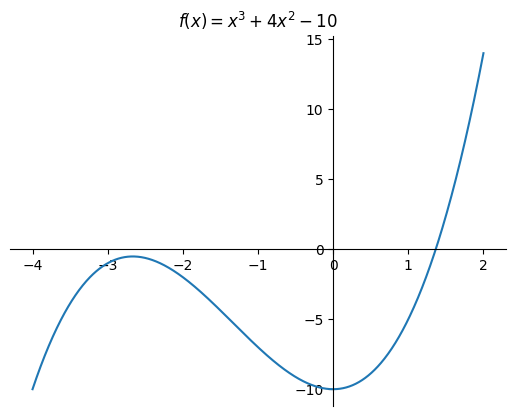

In [155]:
dibuja_funcion(f, -4, 2)

Para poder aproximar por el método de bisección, codificamos dicho método.

In [156]:
def biseccion(f, a, b, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de la biseccion.

    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        a (float): Límite inferior del intervalo.
        b (float): Límite superior del intervalo.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.

    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula de la secante fue cero.
    """
        
    niter = 0
    cont = True
    exit = ''

    x_n = (a + b) / 2    


    while cont:
        niter += 1

        # Preparamos el intervalo
        if sign(f(a)) != sign(f(x_n)):
            b = x_n
        else:
            a = x_n

        # Actualizamos las aproximaciones
        x_n_1 = x_n
        x_n = (a + b) / 2

        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False
            

    return x_n, niter, exit

Aproximamos ahora dicha raíz con el método de bisección con al menos 3 cifras decimales exactas. Como vemos, en este caso es necesario imponer precisión, puesto que la sucesión de errores con este método no tiene por qué ser decreciente.

In [157]:
print(f"Solución exacta: {np.roots([1,4,0,-10])[2]}")

print("-------------- Con Precision --------------")
getcontext().prec = 28
x_n, iter, exit = biseccion(f, Decimal(1), Decimal(2), prec=1e-3)
salida(x_n, iter, exit)

print("-------------- Con Tolerancia --------------")
x_n, iter, exit = biseccion(f, Decimal(1), Decimal(2), tol=1e-3)
salida(x_n, iter, exit)

Solución exacta: (1.3652300134140969+0j)
-------------- Con Precision --------------
Numero de iteraciones: 8
Posible solución exacta: 1.365234375
-------------- Con Tolerancia --------------
Numero de iteraciones: 9
Aproximación solicitada: 1.3642578125


Veamos ahora cuántas iteraciones son necesarias para conseguir 5 cifras decimales exactas.

In [158]:
getcontext().prec = 28
x_n, iter, exit = biseccion(f, Decimal(1), Decimal(2), prec=1e-5)
salida(x_n, iter, exit)

Numero de iteraciones: 17
Posible solución exacta: 1.365230560302734375


Como vemos, hacen falta 17 iteraciones. Aproximamos ahora dicha raíz con el método de Newton-Raphson hasta que la diferencia en valor absoluto entre dos aproximaciones consecutivas sea  inferior a  $10^{-3}$. Como vemos, la elección del extremo del intervalo en este caso no es relevante, puesto que las primeras 9 cifras significativas coinciden.


In [159]:
getcontext().prec = 28
print("-------------- Partiendo del Extremo Inferior --------------")
x_n, iter, exit = newtonRaphson(f, Decimal(1), tol=1e-3)
salida(x_n, iter, exit)
print("-------------- Partiendo del Extremo Superior --------------")
x_n, iter, exit = newtonRaphson(f, Decimal(2), tol=1e-3)
salida(x_n, iter, exit)

-------------- Partiendo del Extremo Inferior --------------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 4
Aproximación solicitada: 1.365230013435370613090038792
-------------- Partiendo del Extremo Superior --------------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 4
Aproximación solicitada: 1.365230013916166201377957374


## Ejercicio 5

> **Ejercicio 5.** Use el método de Newton-Raphson para aproximar las soluciones de las siguientes ecuaciones con tolerancia $10^{-5}$ , partiendo de un valor adecuado, próximo a cada una de ellas en cada caso.
> 
> 1. $3x=2+x^2-e^x$.
> 
> 2. $x^2+10 \cos x+x=0$.

#### Ejercicio 5.1

En este caso, trabajamos con la función $f(x) = 3x - 2 - x^2 + e^x$.

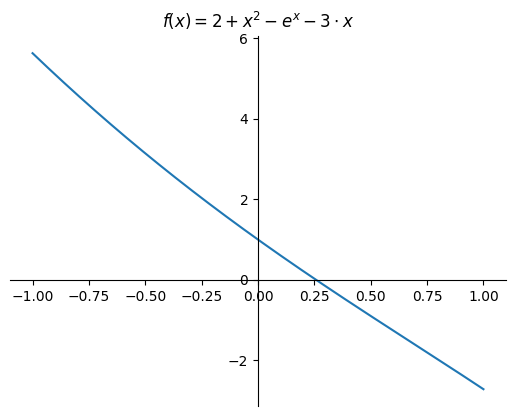

In [160]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = 2+x^2-e^x - 3x$.
    """
    return 2 + x**2 - np.exp(x) - 3*x
dibuja_funcion(f, -1, 1)

In [161]:
getcontext().prec = 28
x_n, iter, exit = newtonRaphson(f, Decimal(0.25), tol=1e-5)
salida(x_n, iter, exit)

h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 2
Aproximación solicitada: 0.2575302854371923839410050889


##### Ejercicio 5.2

En este caso, trabajamos con la función $f(x) = x^2 + 10 \cos x + x$.

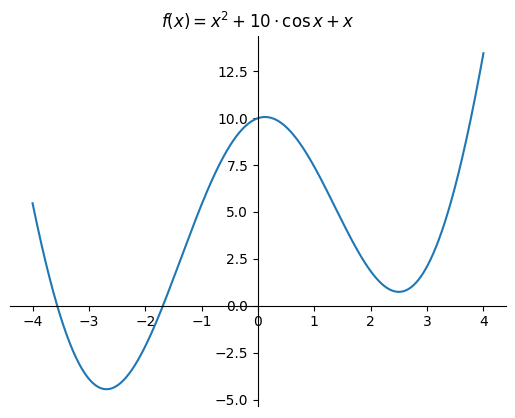

In [162]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = x^2+10 cos(x)+x$.
    """
    return x**2 + 10 * np.cos(x) + x
dibuja_funcion(f, -4, 4, forzar_ejeX_0=True)


In [163]:
getcontext().prec = 28
# Como el coseno no admite un valor Decimal, tenemos que pasarlo normal
x_n, iter, exit = newtonRaphson(f, 0.25, tol=1e-5)
salida(x_n, iter, exit)

h: <class 'float'>, x: <class 'float'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>, x: <class 'numpy.float64'>
h: <class 'numpy.float64'>

## Ejercicio 6

> **Ejercicio 6.** Para la función  $ f(x)= 3 x^2+e^x-1$,
> 
> 1. Encuentre, mediante el método de bisección una aproximación de la raíz en $[0,1]$ con, al menos, cuatro decimales exactos (tol =$10^{-4}$), y determine el número de iteraciones realizadas;
> 
> 2. Encuentre, mediante el método de Newton-Raphson, una aproximación de la raíz en $[0,1]$ con una tolerancia de $10^{-4}$, partiendo de $x_0=0$, y determine el número de iteraciones realizadas.  

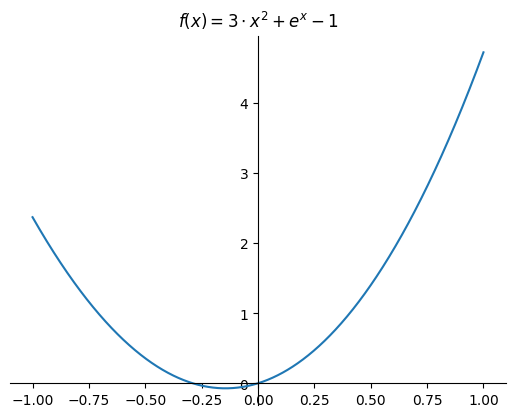

In [164]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = 3x^2+e^x-1
    """
    return 3*x**2 + np.exp(x) - 1
dibuja_funcion(f, -1, 1, forzar_ejeX_0=True)

Usamos ahora el método de bisección una aproximación de la raíz en $[0,1]$ con, al menos, cuatro decimales exactos. Vemos que el número de iteraciones realizadas es 13.

Como vemos, se trata de un caso peculiar, puesto que la raíz exacta es uno de los extremos del intervalo.

In [165]:
x_n, iter, exit = biseccion(f, Decimal(0), Decimal(1), prec=1e-4)
salida(x_n, iter, exit)

Numero de iteraciones: 13
Posible solución exacta: 0.00006103515625


Aplicamos ahora el método de Newton-Raphson para encontrar una aproximación de la raíz en $[0,1]$ con una tolerancia de $10^{-4}$, partiendo de $x_0=0$. 

In [166]:
x_n, iter, exit = newtonRaphson(f, Decimal(0), tol=1e-4)
salida(x_n, iter, exit)

h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 1
Posible solución exacta: 0


## Ejercicio 7

> **Ejercicio 7.** Implemente el método de iteración funcional de Steffensen para una función $f$. En particular, para la función $f(x)=e^x-3$:
> * Represente gráficamente las funciones $g$ definidas tanto para el método de Newton-Raphson como para el método de Steffensen, comprobando que ambas poseen un punto fijo en la raíz de $f$.
> * Aproxima su única raíz utilizando el método de Steffensen:
>     * Cambiando la precisión a 5 cifras significativas.
>     * Con la precisión por defecto y aproximando la raíz con 28 cifras significativas.

Codificamos ahora el método de Steffensen. En este caso, la función $g$ que se define es la siguiente:
$$g(x) = x - \frac{f^2(x)}{f(x + f(x))-f(x)}$$

In [167]:
def Steffensen(f, x0, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de Steffensen.

    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.

    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula fue cero.
    """
        
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n = x0


    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_n_1 = x_n
        
        f_x_n_1 = f(x_n_1)

        
        numerador = f_x_n_1**2
        denominador = f(x_n_1 + f_x_n_1) - f_x_n_1

        if denominador == 0:
            return x_n_1, niter, 'denominador cero'

        x_n = x_n_1 - (numerador / denominador)
        
        
        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False

    return x_n, niter, exit

Definimos ahora la función $f(x) = e^x - 3$ con la que vamos a trabajar en este ejercicio.

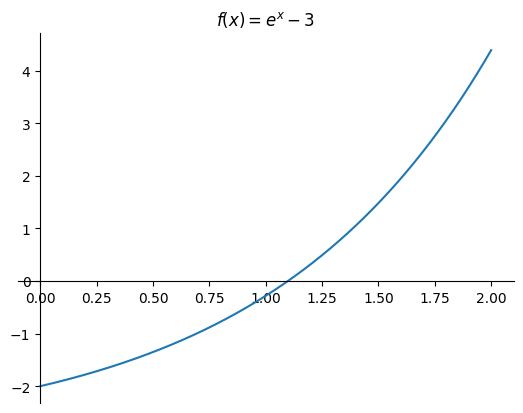

In [168]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = e^x - 3$.
    """
    return np.exp(x) - 3
dibuja_funcion(f, 0, 2)

La función $g$ que se define para el método de Steffensen es la siguiente:
$$g(x) = x - \frac{f^2(x)}{f(x + f(x))-f(x)}$$
En su representación gráfica podemos observar que solo tiene un único punto fijo, que es la raíz de $f$. Podría parecer que se van a cortar, pero se trata de una asíntota.

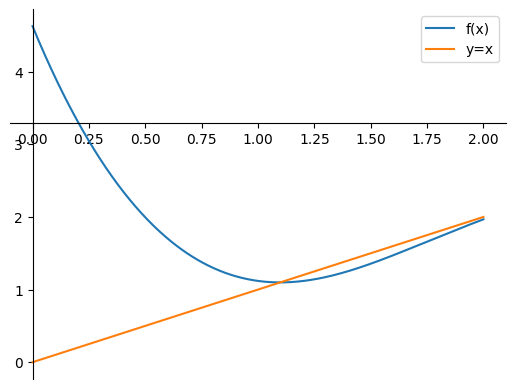

In [169]:
def func_Steffensen(f):
    """
    Función para calcular la función $g$ del método de Steffensen.
    """
    def g(x):
        numerador = f(x)**2
        denominador = f(x + f(x)) - f(x)
        return x - (numerador / denominador)
    
    return g
dibuja_funcion(func_Steffensen(f), 0, 2, Y_X=True, titulo=False)

La función $g$ que se define para el método de Newton-Ramphson es la siguiente:
$$g(x) = x - \frac{f(x)}{f'(x)}$$
En su representación gráfica podemos observar que solo tiene un único punto fijo, que es la raíz de $f$.

h: <class 'float'>, x: <class 'numpy.ndarray'>
h: <class 'int'>, x: <class 'int'>
h: <class 'int'>, x: <class 'int'>


/tmp/ipykernel_6521/317807026.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return (f(x + h) - f(x - h)) / (2 * h)


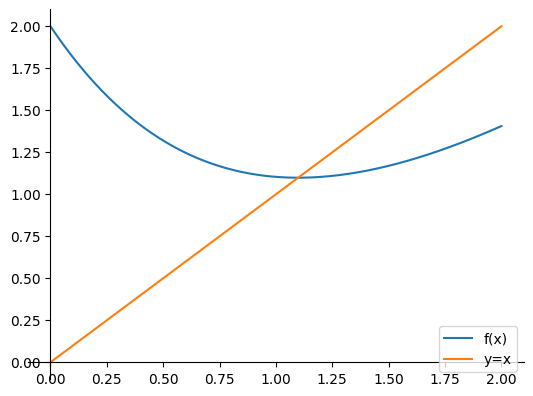

In [170]:
def func_Newton_Ramphson(f):
    """
    Función para calcular la función $g$ del método de Newton-Ramphson.
    """
    def g(x):
        numerador = f(x)
        denominador = df(x)
        return x - (numerador / denominador)
    
    return g
dibuja_funcion(func_Newton_Ramphson(f), 0, 2, Y_X=True, titulo=False)

Aproximamos ahora la raíz con la precisión de 5 cifras significativas. No obstante, antes de aproximarla, como sabemos que la raíz es $\ln(3)$, imprimiremos su valor exacto para poder comparar.

In [171]:
print(f"Solución exacta: {sp.N(sp.log(3), 28)}")
getcontext().prec = 5
x_n, iter, exit = Steffensen(f, Decimal(1))
salida(x_n, iter, exit)

Solución exacta: 1.098612288668109691395245237
Numero de iteraciones: 3
Posible solución exacta: 1.0986


Notemos que el valor inicial es bastante relevante. Vemos que, probando con $0$ como semilla, el método no converge.

In [172]:
getcontext().prec = 5
x_n, iter, exit = Steffensen(f, Decimal(0))
salida(x_n, iter, exit)

Numero de iteraciones: 2
Aproximación solicitada: 4.6259


In [173]:
getcontext().prec = 28
x_n, niter, exit = Steffensen(f, Decimal(1))
salida(x_n, niter, exit)

Numero de iteraciones: 6
Posible solución exacta: 1.098612288668109691395245237


## Ejercicio 8

> **Ejercicio 8.** Implemente el método de aceleración de la convergencia de Steffensen y aplíquelo a una sucesión de valores obtenidos mediante iteración funcional de Newton-Raphson a la función $f(x) = e^x -3$. Compare las aproximaciones tras 4 iteraciones del método de Newton-Raphson, aceleración de la convergencia de Aitken y aceleración de la convergencia de Steffensen.

Codificamos en primer lugar ambos métodos de aceleración de la convergencia, tanto el de Aitken como el de Steffensen. El método base que se usará es el de Newton-Raphson, que ya hemos definido anteriormente.

In [174]:
def Aitken(f, x0, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de Aitken. Como método base usa N-R
    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.
    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula fue cero.
    """
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n_1 = x0
    x_n_2, _ , exit = newtonRaphson(f, x_n_1, nmax=1, tol=tol, prec=prec)

    x_hat_n = x0

    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_hat_n_1 = x_hat_n

        x_n = x_n_1
        x_n_1 = x_n_2
        x_n_2, _ , exit = newtonRaphson(f, x_n_1, nmax=1, tol=tol, prec=prec)

        numerador = (x_n_1 - x_n)**2
        denominador = x_n_2 - 2*x_n_1 + x_n

        
        if denominador == 0 or exit == 'denominador cero':
            return x_hat_n_1, niter, 'denominador cero'

        
        x_hat_n = x_n - (numerador / denominador)
        
        
        if abs(f(x_hat_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_hat_n - x_hat_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False

    return x_hat_n, niter, exit

In [175]:
def acel_Steffensen(f, x0, nmax=nmax, tol=tol, prec=prec):
    """Aproxima la raíz de una función utilizando el método de Steffensen.
    Args:
        f (function): Función continua cuya raíz se desea encontrar. Debe aceptar un solo argumento (float).
        x0 (float): Primera aproximación inicial. Semilla.
        nmax (int): Número máximo de iteraciones permitidas.
        tol (float): Tolerancia entre dos aproximaciones sucesivas.
        prec (int): Precisión de decimales para determinar si se ha alcanzado la raíz.
    Returns:
        tuple: Una tupla con:
            - x (float): Aproximación de la raíz.
            - iter (int): Número de iteraciones realizadas.
            - exit (str): Motivo de salida del bucle:
                - 'precision': Se alcanzó la precisión deseada.
                - 'tolerancia': Se alcanzó la tolerancia deseada.
                - 'iteraciones': Se alcanzó el número máximo de iteraciones.
                - 'denominador cero': El denominador de la fórmula fue cero.
    """
    niter = 0
    cont = True
    exit = ''

    # Construimos iteraciones iniciales
    x_n = x0

    while cont:
        niter += 1

        # Actualizamos las aproximaciones
        x_n_1 = x_n

        x_n, _ , exit = Aitken(f, x_n_1, nmax=1, tol=tol, prec=prec)
        
        if exit == 'denominador cero':
            return x_n_1, niter, 'denominador cero'
              
        if abs(f(x_n)) < prec:
            exit = 'precision'
            cont = False
        elif abs(x_n - x_n_1) < tol:
            exit = 'tolerancia'
            cont = False
        elif niter == nmax:
            exit = 'iteraciones'
            cont = False

    return x_n, niter, exit

Con el siguiente ejemplo, vemos que efectivamente funciona, es decir, que cada una de las aceleraciones de la convergencia nos proporciona el resultado preciso con un menor número de iteraciones.

In [176]:
x0 = Decimal(2)

print(f"------- Newton Raphson -------")
x_n, niter, exit = newtonRaphson(f, x0)
salida(x_n, niter, exit)
print(f"------- Aitken -------")
x_n, niter, exit = Aitken(f, x0)
salida(x_n, niter, exit)
print(f"------- Aceleración de Steffensen -------")
x_n, niter, exit = acel_Steffensen(f, x0)
salida(x_n, niter, exit)

------- Newton Raphson -------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 7
Posible solución exacta: 1.098612288668109691395245237
------- Aitken -------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 6
Posible solució

In [177]:
x0 = Decimal(2)
iters = 4

print(f"Solución exacta: {sp.N(sp.log(3), 28)}")
print(f"------- Newton Raphson -------")
x_n, niter, exit = newtonRaphson(f, x0, nmax=iters)
salida(x_n, niter, exit)
print(f"------- Aitken -------")
x_n, niter, exit = Aitken(f, x0, nmax=iters)
salida(x_n, niter, exit)
print(f"------- Aceleración de Steffensen -------")
x_n, niter, exit = acel_Steffensen(f, x0, nmax=iters)
salida(x_n, niter, exit)

Solución exacta: 1.098612288668109691395245237
------- Newton Raphson -------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 4
Se alcanzó el número máximo de iteraciones.
Última aproximación: 1.098612694533310907658385395
------- Aitken -------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
Numero de iteraciones: 4
Se alcanzó el número máximo de iteraciones.
Última aproximación: 1.098612288485220773503428235
------- Aceleración de Steffensen -------
h: <class 'decimal.Decimal'>, x: <class 'decimal.Decimal'>
h: <class 'decimal.Decimal'

Aquí de nuevo vemos que Steffensen se comporta mejor que los otros dos métodos. De hecho, es el único que llega a la posible solución exacta.

## Ejercicio 9

> **Ejercicio 9** Utilice las órdenes apropiadas de Python para aproximar todos los puntos donde se anulan las funciones siguientes (si es necesario, represéntelas gráficamente):
> 
> i) $f(x)=x^7-x^4+2$ ,
> 
> ii) $f(x)=x^7+\cos  x-3$.

#### Ejercicio 9.1

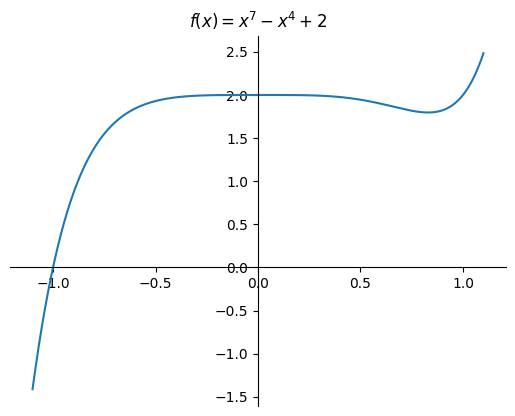

In [178]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = x^7-x^4+2$.
    """
    return NewtonHorner([1,0,0,-1,0,0,0,2], x)
dibuja_funcion(f, -1.1, 1.1)

Procedemos en primer lugar a resolverlo de forma simbólica. Vemos que tan solo tiene una raíz real (el $-1$), y el resto de las raíces son las 6 raíces complejas del polinomio $x^6 - x^5 + x^4-2x^3+2x^2-2x+2$.

In [179]:
x = sp.Symbol('x')
print(sp.solve( x**7-x**4+2, x ))

[-1, CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 0), CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 1), CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 2), CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 3), CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 4), CRootOf(x**6 - x**5 + x**4 - 2*x**3 + 2*x**2 - 2*x + 2, 5)]


Una vez vistas las soluciones exactas, nos interesa obtener las aproximaciones. Al tratarse de un polinomio, la mejor opción será usarla función `roots` de `NumPy`.

In [180]:
print(np.roots([1,0,0,-1,0,0,0,2]))

[ 1.06110281+0.37638405j  1.06110281-0.37638405j  0.15199934+1.01945595j
  0.15199934-1.01945595j -0.71310215+0.98823189j -0.71310215-0.98823189j
 -1.        +0.j        ]


#### Ejercicio 9.2

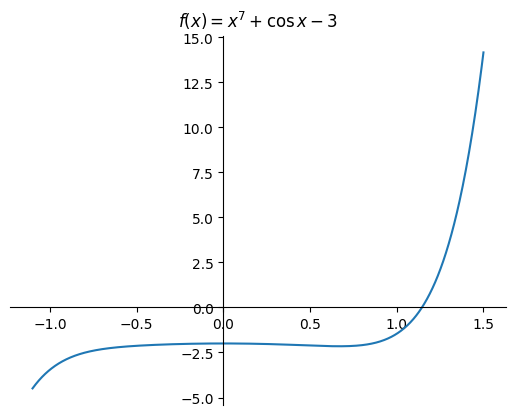

In [181]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = x^7+cos(x)-3
    """
    return x**7 + np.cos(x) - 3
dibuja_funcion(f, -1.1, 1.5)

Procedemos en primer lugar a intentar resolverlo de forma simbólica. No obstante, descomentando dicha línea vemos que no es posible.

In [182]:
#print(sp.solve( x**7-sp.cos(x)-3, x ))

Por tanto, tan solo nos queda aproximarla. Como no se trata de un polinomio, tenemos que optar por un método distinto de `roots`. Usamos `fsolve` de `SciPy`, que nos permite aproximar la raíz de una función. A este método debemos pasarle como parámetro un valor cercano a la raíz, que será la semilla.

In [183]:

from scipy.optimize import fsolve
print(fsolve(f, -0.7))

[1.14545981]


Notemos que la elección de la raíz es vital, y en este ejercicio debe realizarse de forma cuidadosa. Por ejemplo, si elegimos el valor de $-0.5$ como raíz, el método no es convergente (y nos avisa de ello).

In [184]:
print(fsolve(f, -0.5))

[-0.00327567]


/tmp/ipykernel_6521/2234084708.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  print(fsolve(f, -0.5))


## Ejercicio 10

> **Ejercicio 10:** De los métodos implementados en los anteriores ejercicios, utiliza el método o métodos numéricos que desees para aproximar la primera raíz de la función
> $$
> f:[0,1]\longrightarrow\mathbb R \\
> f(x) = x(1-x)\sin\left(\dfrac{2\pi}{x+1/10}\right)
> $$
> que sea mayor que una milésima con una precisión de 28 cifras significativas y utilizando el menor número de iteraciones posible. Imprime por pantalla tu aproximación y el número de iteraciones utilizado.

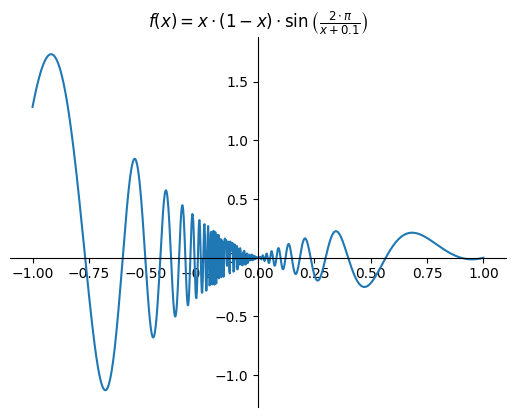

In [203]:
def f(x):
    """
    Función para calcular numéricamente $f(x) = x(1-x)sen(2 pi / x + 1/10)
    """
    return x*((1-x))*np.sin(( (2*np.pi)/(x + 0.1) ))
dibuja_funcion(f, -1, 1)

Como podemos ver, esta función tiene una gran cantidad de raíces. Como buscamos la primera raíz mayor que una milésima ($0.001$), representamos la función con mayor precisión en dicho valor.

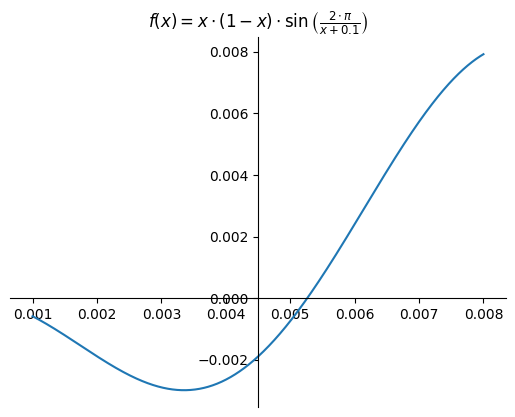

In [186]:
dibuja_funcion(f, 0.001, 0.008)

Como primera opción, podríamos usar el método de bisección en el intervalo $[0.001,0.008]$, puesto que vemos que tan solo tiene una raíz en dicho intervalo, por lo que el método (que sabemos que siempre es convergente), convergerá a la raíz que buscamos. Este método evidentemente no es el más eficiente, pero es una primera opción.

In [204]:
print(f"------Bisección-------")
x_n, niter, exit = biseccion(f, 0.001, 0.008)
salida(x_n, niter, exit)

------Bisección-------
Numero de iteraciones: 45
Aproximación solicitada: 0.005263157894736779


Como segunda opción, podríamos intentar usar el método de Newton-Raphson usando la aceleración de Steffensen (que sabemos que reduce el número de iteraciones). Emplearemos de aquí en adelante este método, puesto que Newton-Raphson es, por norma general, el método más eficiente visto hasta el momento. Usamos además la aceleración de Steffensen, que nos permite reducir el número de iteraciones.


No obstante, como vemos, no converge a la raíz buscada. Esto se debe a que nada nos garantiza que las iteraciones de los métodos empleados creen una sucesión de aproximaciones crecientes, ni nada por el estilo.

In [228]:

print(f"------Aceleración de Steffensen con N-R. x_0=0.001-------")
x_n, niter, exit = acel_Steffensen(f, x0 = 0.001)
salida(x_n, niter, exit)

------Aceleración de Steffensen con N-R. x_0=0.001-------
Numero de iteraciones: 28
Posible solución exacta: -3.142097159605307171719055618e-16


Como última opción, tan solo nos queda emplear distintas semillas hasta que una de ellas nos proporcione una aproximación de la raíz buscada. Esto podemos hacerlo porque previamente la hemos representado, y sabemos que la raíz buscada es caroximadamente $0.005$.

In [206]:
print(f"------Aceleración de Steffensen con N-R. x_0=0.004-------")
x_n, niter, exit = acel_Steffensen(f, x0=0.004)
salida(x_n, niter, exit)
print(f"------Aceleración de Steffensen con N-R. x_0=0.005-------")
x_n, niter, exit = acel_Steffensen(f, x0=0.005)
salida(x_n, niter, exit)
print(f"------Aceleración de Steffensen con N-R. x_0=0.006-------")
x_n, niter, exit = acel_Steffensen(f, x0=0.006)
salida(x_n, niter, exit)

------Aceleración de Steffensen con N-R. x_0=0.004-------
Numero de iteraciones: 5
Aproximación solicitada: 0.005263157894736837
------Aceleración de Steffensen con N-R. x_0=0.005-------
Numero de iteraciones: 4
El denominador se volvió cero, no se puede continuar.
Última aproximación: 0.005263157894736829
------Aceleración de Steffensen con N-R. x_0=0.006-------
Numero de iteraciones: 4
El denominador se volvió cero, no se puede continuar.
Última aproximación: 0.005263157894736826


Notemos que en los tres casos converge a la raíz buscada, pero en ninguno de ellos obtenemos una posible solución exacta. En el primer caso obtenemos dos aproximaciones muy cercanas que, por el valor de tolerancia, se sale del método. En los otros dos casos, obtenemos una división entre $0$ por lo que directamente no puede continuar. La respuesta por tanto no es satisfactoria. Esto se debe a que trabajamos con valores de tolerancia y presición muy altos.

Hasta ahora, no hemos podido trabajar con el paquete `Decimal` en este ejercicio, puesto que la función `np.sin` no es compatible con dicho paquete. Trabajamos ahora por tanto con el paquete `mpmath`, que nos permite trabajar con números de precisión arbitraria. Definamos la precición a $28$.

In [190]:
import mpmath as mp
mp.mp.dps = 28

Como hemos cambiado de módulo con el que trabajar, usamos también la función `mpmath.sin` para calcular el seno.

In [ ]:
def f(x):
    """
    Función para calcular con mpmath $f(x) = x(1-x)sen(2 pi / x + 1/10)
    """
    return x*((1-x))*mp.sin(( (2*mp.pi)/(x + 0.1) ))

Veamos ahora la salida que obtenemos para el método de aceleración de Steffensen, recordando que anteriormente no hemos llegado a resultados satisfactorios para ninguna de las tres semillas empleadas.

In [227]:
print(f"------Aceleración de Steffensen con N-R. x_0=0.003-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.003), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)
print(f"\n------Aceleración de Steffensen con N-R. x_0=0.004-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.004), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)
print(f"\n------Aceleración de Steffensen con N-R. x_0=0.005-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.005), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)
print(f"\n------Aceleración de Steffensen con N-R. x_0=0.006-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.006), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)
print(f"\n------Aceleración de Steffensen con N-R. x_0=0.007-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.007), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)
print(f"\n------Aceleración de Steffensen con N-R. x_0=0.008-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.008), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)

------Aceleración de Steffensen con N-R. x_0=0.003-------
Numero de iteraciones: 29
Posible solución exacta: -3.2859801378057097160816723e-16

------Aceleración de Steffensen con N-R. x_0=0.004-------
Numero de iteraciones: 5
Posible solución exacta: 0.00526315789473683655414803477

------Aceleración de Steffensen con N-R. x_0=0.005-------
Numero de iteraciones: 4
Posible solución exacta: 0.005263157894736836554148034769

------Aceleración de Steffensen con N-R. x_0=0.006-------
Numero de iteraciones: 4
Posible solución exacta: 0.00526315789473683655414803477

------Aceleración de Steffensen con N-R. x_0=0.007-------
Numero de iteraciones: 4
Posible solución exacta: 0.005263157894736836554148034769

------Aceleración de Steffensen con N-R. x_0=0.008-------
Numero de iteraciones: 29
Posible solución exacta: -3.495755294732363531130441464e-16


En este caso, vemos que las salidas son satisfactorias en todos los casos. Además, hemos usado diversas semillas para ver que algunas convergen a la raíz buscada y otras convergen a otras raíces. Observamos además que el número de iteraciones es muy bajo, por lo que el método es muy eficiente.

Por tanto, la opción por la que optamos es el método de aceleración de Steffensen usando la semilla $0.005$.

In [226]:
print(f"------Aceleración de Steffensen con N-R. x_0=0.005-------")
x_n, niter, exit = acel_Steffensen(f, x0=mp.mpf(0.005), tol=1e-28, prec=1e-28)
salida(x_n, niter, exit)

------Aceleración de Steffensen con N-R. x_0=0.005-------
Numero de iteraciones: 4
Posible solución exacta: 0.005263157894736836554148034769
